# Supernova distances and redshifts (Part 2)

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the kernels submodule of sklearn.gaussian_process
- **Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.**
- **Interpret the results.**

In [18]:
import numpy as np
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import sys
sys.path.append(r"C:\Users\Phisio97\Documents\Astrostatistics\Notebooks")
from Utilities import plot_settings
from Utilities.utils import train_test_cv_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [32]:
X = np.vstack([z_sample, mu_sample, dmu]).T
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=42)

Text(0.5, 1.0, 'Raw Data')

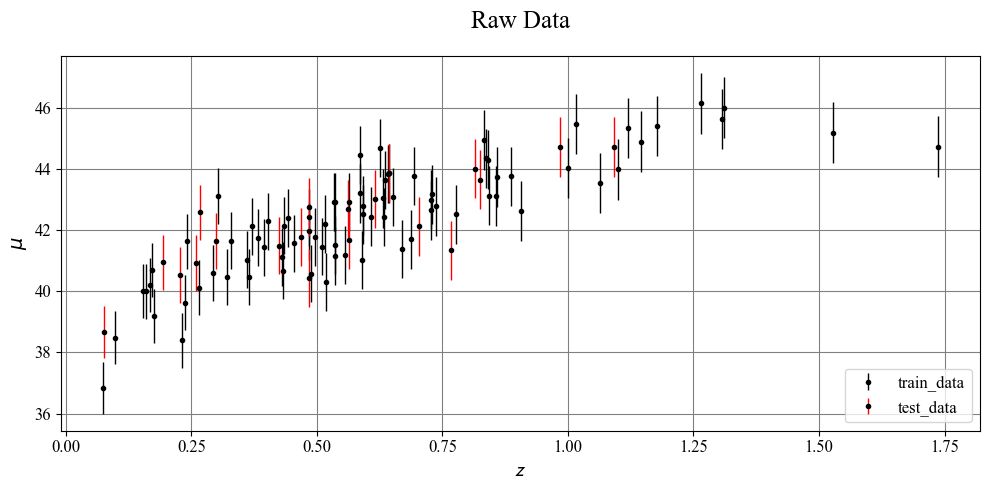

In [33]:
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.k', ecolor='k', lw=1,label='train_data')
#plt.errorbar(X_cv[:, 0], X_cv[:, 1], yerr=X_cv[:, 2], fmt='.k', ecolor='blue', lw=1,label='cv_data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.k', ecolor='red', lw=1,label='test_data')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Raw Data')

In [34]:
import random
random_seed = 54

np.random.seed(random_seed)
random.seed(random_seed)

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the kernels submodule of sklearn.gaussian_process
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
- Interpret the results.

In [35]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, RationalQuadratic, ConstantKernel
from sklearn.model_selection import KFold, GridSearchCV

In [36]:
K = Matern(length_scale=1.0, nu=1.0) + WhiteKernel(noise_level=1.0)
GPR = GaussianProcessRegressor(kernel=K, normalize_y=True)

In [42]:
param_grid = {
    'kernel__k1__length_scale': np.logspace(-1, 1, 5),
    'kernel__k1__nu'          : [0.5, 1.5, 2.5, np.inf],
    'kernel__k2__noise_level' : np.logspace(-5, -1, 5)
}

custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(GPR, 
                    param_grid, 
                    cv=custom_cv, 
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    refit=True,
                    #n_jobs=-1
                    )
grid.fit(X_train[:, 0].reshape(-1, 1), X_train[:, 1])

score = grid.best_score_
print(f"Best score (neg MSE): {score:.4f}")
print(f"Best params: {grid.best_params_}\n")

Best score (neg MSE): -0.9600
Best params: {'kernel__k1__length_scale': np.float64(3.1622776601683795), 'kernel__k1__nu': 2.5, 'kernel__k2__noise_level': np.float64(0.1)}



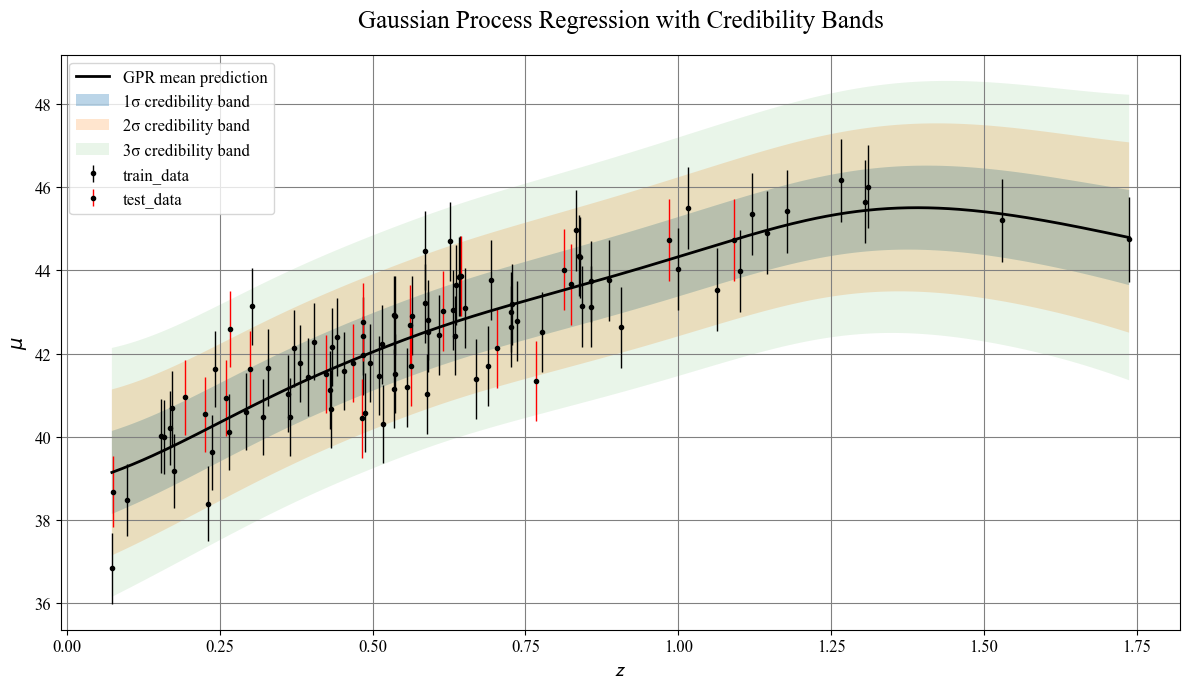

In [43]:
# Predict over a dense grid
x_fit = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 300).reshape(-1, 1)
y_mean, y_std = grid.best_estimator_.predict(x_fit, return_std=True)

# Credibility bands: ±1σ, ±2σ, ±3σ
bands = {
    '1σ': (y_mean.ravel() - 1*y_std, y_mean.ravel() + 1*y_std, 0.3),
    '2σ': (y_mean.ravel() - 2*y_std, y_mean.ravel() + 2*y_std, 0.2),
    '3σ': (y_mean.ravel() - 3*y_std, y_mean.ravel() + 3*y_std, 0.1),
}

# Plot
plt.figure(figsize=(12, 7))
plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.k', ecolor='k', lw=1,label='train_data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.k', ecolor='red', lw=1,label='test_data')

plt.plot(x_fit, y_mean, 'k-', label='GPR mean prediction')

# Fill credibility regions
for label, (lower, upper, alpha) in bands.items():
    plt.fill_between(x_fit.ravel(), lower, upper, alpha=alpha, label=f'{label} credibility band')

plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.title("Gaussian Process Regression with Credibility Bands")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from sklearn.model_selection import learning_curve

gpr = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    gpr,
    X_train[:, 0].reshape(-1,1),
    X_train[:, 1],
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    cv=custom_cv,
    shuffle=True,
    random_state=42,
    #n_jobs=-1
)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)


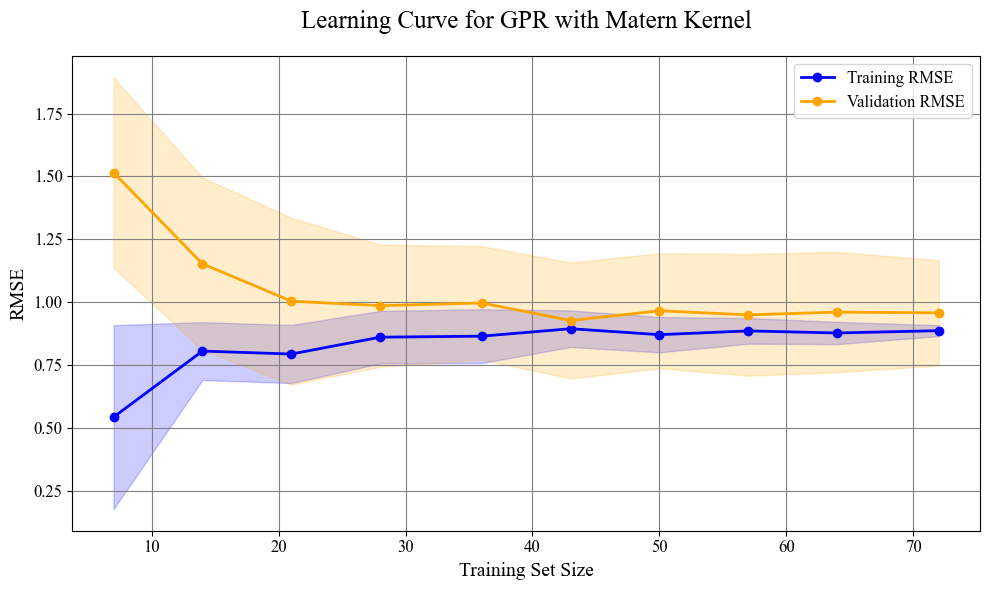

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_rmse, axis=1), 'o-', label='Training RMSE', color='blue')
plt.plot(train_sizes, np.mean(val_rmse, axis=1), 'o-', label='Validation RMSE', color='orange')
plt.fill_between(train_sizes,
                 np.mean(train_rmse, axis=1) - np.std(train_rmse, axis=1),
                 np.mean(train_rmse, axis=1) + np.std(train_rmse, axis=1),
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 np.mean(val_rmse, axis=1) - np.std(val_rmse, axis=1),
                 np.mean(val_rmse, axis=1) + np.std(val_rmse, axis=1),
                 alpha=0.2, color='orange')

plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve for GPR with Matern Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comments: 

1. Training RMSE starts low (~0.55) with small datasets, as expected. Gradually increases and stabilizes around 0.88–0.90, showing the model is not memorizing but learning general patterns.
2. Validation RMSE begins high (~1.5), indicating high variance with little training data. Quickly decreases and plateaus around 0.95, converging toward the training RMSE.
3. The gap shrinks significantly with larger training sizes, suggesting the model is not overfitting. This indicates a well-regularized model, likely aided by the Matern kernel’s limited smoothness.

In [50]:
train_sizes, train_scores, val_scores = learning_curve(
    gpr,
    X_test[:, 0].reshape(-1,1),
    X_test[:, 1],
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    cv=custom_cv,
    shuffle=True,
    random_state=42,
    #n_jobs=-1
)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)


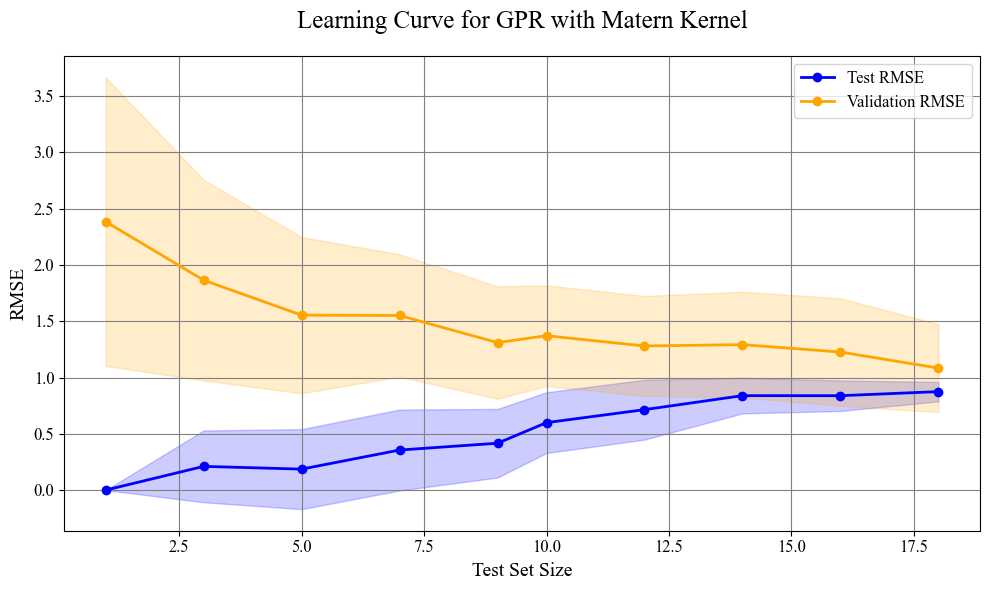

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_rmse, axis=1), 'o-', label='Test RMSE', color='blue')
plt.plot(train_sizes, np.mean(val_rmse, axis=1), 'o-', label='Validation RMSE', color='orange')
plt.fill_between(train_sizes,
                 np.mean(train_rmse, axis=1) - np.std(train_rmse, axis=1),
                 np.mean(train_rmse, axis=1) + np.std(train_rmse, axis=1),
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 np.mean(val_rmse, axis=1) - np.std(val_rmse, axis=1),
                 np.mean(val_rmse, axis=1) + np.std(val_rmse, axis=1),
                 alpha=0.2, color='orange')

plt.xlabel('Test Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve for GPR with Matern Kernel')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Comments:

1. Training RMSE starts near zero with very small training sets — as expected (the model overfits small datasets). Increases steadily and flattens out around $~0.85$, indicating convergence to the model's generalization capability.
2. Validation RMSE starts high $(~2.4)$, and this is due to the small test sample size. It then decreases as training size increases, leveling off around $1.1–1.2$, showing improvement but limited by model complexity or data noise.
3. A visible gap remains between train and validation RMSE at all data sizes. This suggests some overfitting, though it's moderate — the Matern kernel is flexible, but you might be hitting the model bias or noise floor.

In [52]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(X_test[:, 1], gpr.predict(X_test[:,0].reshape(-1,1)))

print(f"Final Test Set Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")

Final Test Set Evaluation:
Mean Squared Error (MSE): 0.8573


### Constant * RBF + handle heteroscedastic errors

In [53]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin

class GPRWithAlpha(BaseEstimator, RegressorMixin):
    def __init__(self, kernel=None):
        if kernel is None:
            kernel = ConstantKernel(1.0) * RBF(10) + WhiteKernel(0.05)
        self.kernel = kernel
        self.gpr = None

    def fit(self, X, y):
        alpha = X[:, 2] ** 2
        X_input = X[:, 0].reshape(-1, 1)
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, normalize_y=True)
        self.gpr.fit(X_input, y)
        return self

    def predict(self, X, return_std=False):
        X_input = X[:, 0].reshape(-1, 1)
        return self.gpr.predict(X_input, return_std=return_std)

    def get_params(self, deep=True):
        return {'kernel': self.kernel}

    def set_params(self, **params):
        self.kernel = params['kernel']
        return self

In [55]:
param_grid = {
    'kernel': [
        ConstantKernel(c) * RBF(l)
        for c in np.linspace(1, 10, 10)
        for l in np.logspace(1, 3, 10)
    ]
}

custom_cv = KFold(n_splits=10, shuffle=True, random_state=42)

model = GPRWithAlpha()

grid = GridSearchCV(model, 
                    param_grid, 
                    cv=custom_cv, 
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    refit=True,
                    #n_jobs=-1
                    )

grid.fit(X_train, X_train[:, 1]) 

print(f"Best score (neg MSE): {grid.best_score_:.4f}")
print("Best kernel:")
print(grid.best_params_['kernel'])

Best score (neg MSE): -0.9570
Best kernel:
2.24**2 * RBF(length_scale=129)


In [56]:
from sklearn.model_selection import learning_curve

gpr = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    gpr,
    X_train,               
    X_train[:, 1],         
    train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='neg_mean_squared_error',
    cv=custom_cv,
    shuffle=True,
    #n_jobs=-1
)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

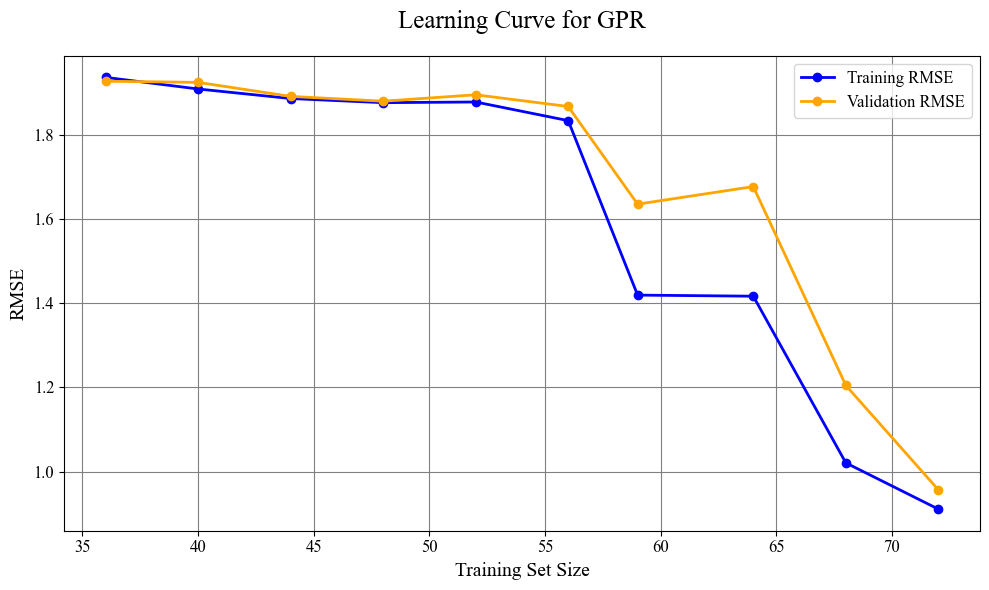

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_rmse, axis=1), 'o-', label='Training RMSE', color='blue')
plt.plot(train_sizes, np.mean(val_rmse, axis=1), 'o-', label='Validation RMSE', color='orange')
"""
plt.fill_between(train_sizes,
                 np.mean(train_rmse, axis=1) - np.std(train_rmse, axis=1),
                 np.mean(train_rmse, axis=1) + np.std(train_rmse, axis=1),
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 np.mean(val_rmse, axis=1) - np.std(val_rmse, axis=1),
                 np.mean(val_rmse, axis=1) + np.std(val_rmse, axis=1),
                 alpha=0.2, color='orange')
"""
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve for GPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
from sklearn.model_selection import learning_curve

gpr = grid.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    gpr,
    X_test,               # full X with all 3 columns
    X_test[:, 1],         # target
    train_sizes=np.linspace(0.5, 1.0, 10),
    scoring='neg_mean_squared_error',
    cv=custom_cv,
    shuffle=True,
    #n_jobs=-1
)

# Convert scores to RMSE
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

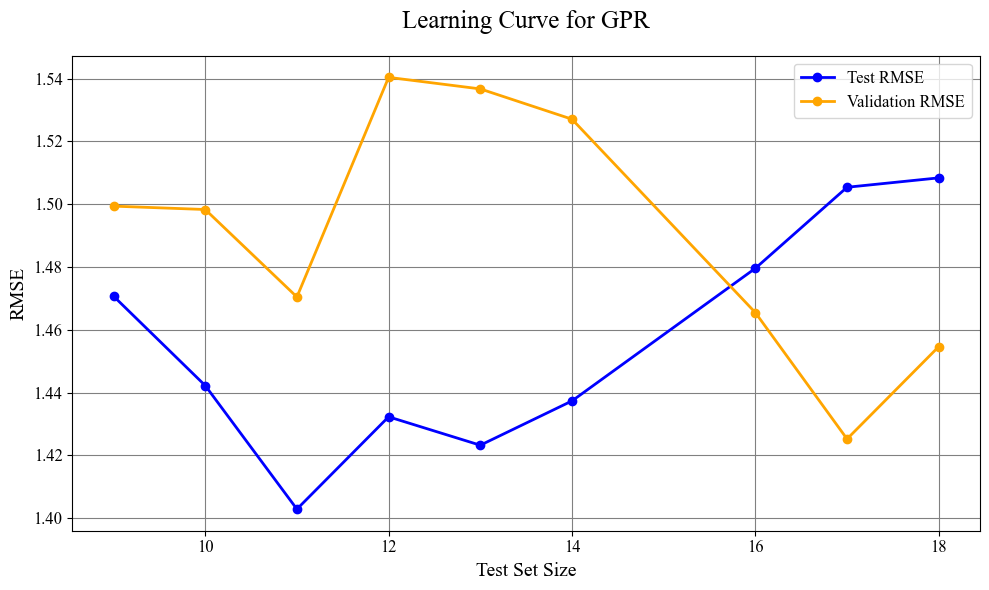

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_rmse, axis=1), 'o-', label='Test RMSE', color='blue')
plt.plot(train_sizes, np.mean(val_rmse, axis=1), 'o-', label='Validation RMSE', color='orange')
"""
plt.fill_between(train_sizes,
                 np.mean(train_rmse, axis=1) - np.std(train_rmse, axis=1),
                 np.mean(train_rmse, axis=1) + np.std(train_rmse, axis=1),
                 alpha=0.2, color='blue')
plt.fill_between(train_sizes,
                 np.mean(val_rmse, axis=1) - np.std(val_rmse, axis=1),
                 np.mean(val_rmse, axis=1) + np.std(val_rmse, axis=1),
                 alpha=0.2, color='orange')
"""
plt.xlabel('Test Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve for GPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


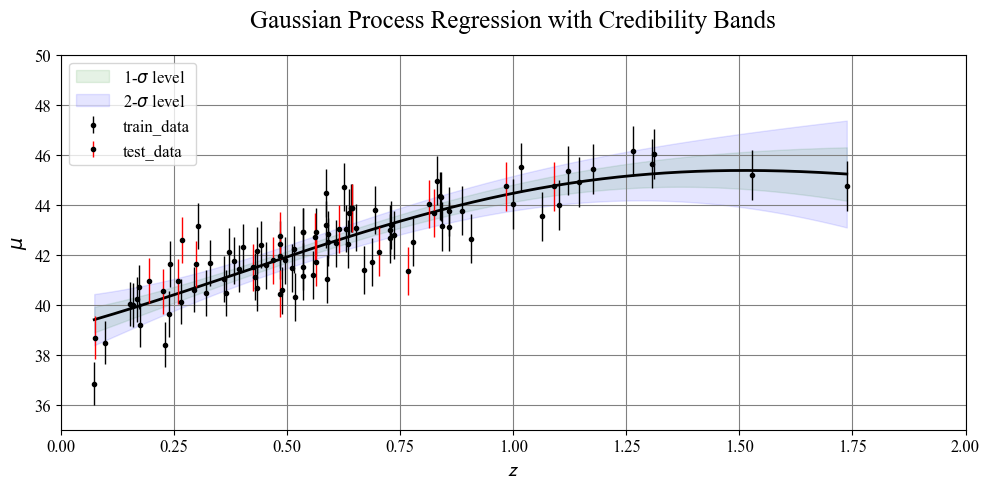

In [60]:
z = np.linspace(X[:,0].min(), X[:,0].max(), 1000)
mu_fit, sigma = gpr.predict(z.reshape(-1,1), return_std=True)

plt.plot(z, mu_fit, '-k')

plt.fill_between(z, mu_fit - sigma, 
                mu_fit + sigma,
                alpha=0.1, color='g', 
                label='1-$\sigma$ level')

plt.fill_between(z, mu_fit - 2* sigma, 
                mu_fit + 2* sigma,
                alpha=0.1, color='b', 
                label='2-$\sigma$ level')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

plt.errorbar(X_train[:, 0], X_train[:, 1], yerr=X_train[:, 2], fmt='.k', ecolor='k', lw=1,label='train_data')
plt.errorbar(X_test[:, 0], X_test[:, 1], yerr=X_test[:, 2], fmt='.k', ecolor='red', lw=1,label='test_data')

plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.title("Gaussian Process Regression with Credibility Bands")
plt.legend()
plt.grid(True)
plt.show()

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

**Think about the pdf of these data in $z$ . Using your GPR fit, generate a set of measurements that respects the statistical properties of the data you were given.**

In [61]:
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

# KDE over original redshift data
z_orig = z_sample
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(z_orig[:, None])
z_candidates = np.linspace(z_orig.min(), 4, 1000)
log_pdf = kde.score_samples(z_candidates[:, None])
pdf = np.exp(log_pdf)

# Sample new z values from KDE
N_new = 10 * len(z_orig)
z_new = np.random.choice(z_candidates, size=N_new, p=pdf / pdf.sum())
z_new = np.sort(z_new)

# Predict GPR mean and std, sample new y values
y_mean, y_std = grid.best_estimator_.predict(z_new.reshape(-1, 1), return_std=True)
y_new = np.random.normal(y_mean, y_std)

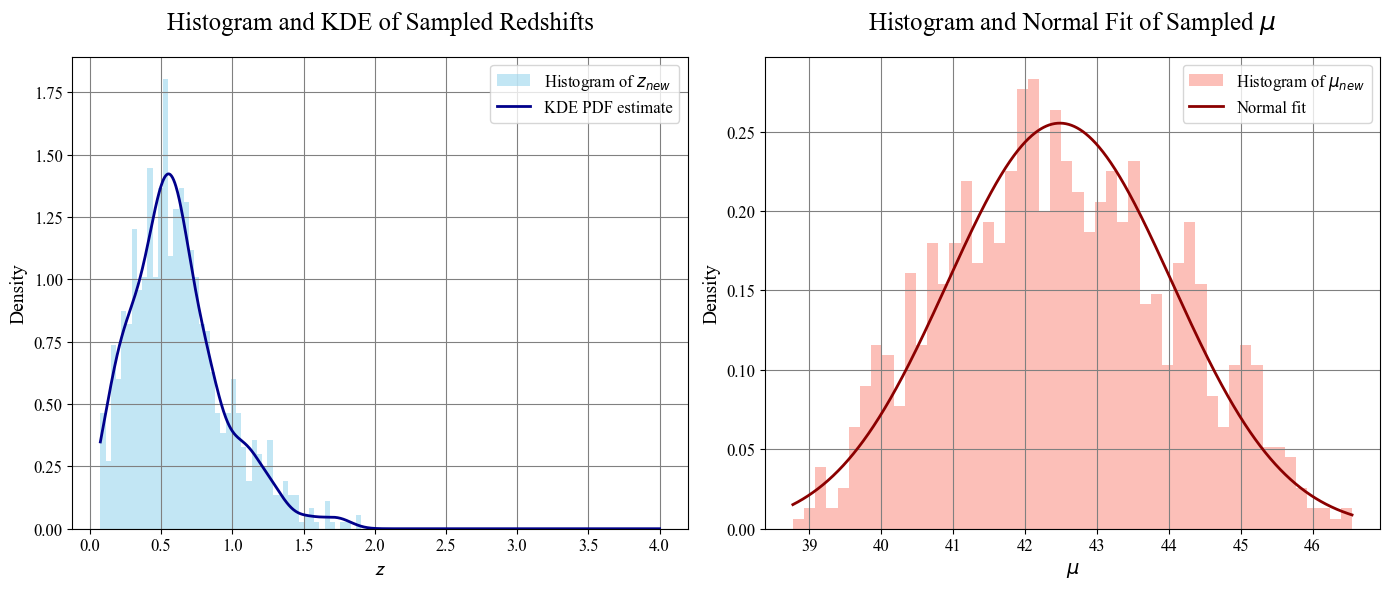

In [62]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(z_new, bins=50, density=True, alpha=0.5, color='skyblue', label='Histogram of $z_{new}$')
plt.plot(z_candidates, pdf, color='darkblue', lw=2, label='KDE PDF estimate')
plt.xlabel(r"$\mathcal{z}$")
plt.ylabel("Density")
plt.title("Histogram and KDE of Sampled Redshifts")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_new, bins=50, density=True, alpha=0.5, color='salmon', label='Histogram of $\mu_{new}$')
y_grid = np.linspace(y_new.min(), y_new.max(), 1000)
y_fit = norm(loc=np.mean(y_new), scale=np.std(y_new)).pdf(y_grid)
plt.plot(y_grid, y_fit, color='darkred', lw=2, label='Normal fit')
plt.xlabel(r"$\mu$")
plt.ylabel("Density")
plt.title("Histogram and Normal Fit of Sampled $\mu$")
plt.legend()

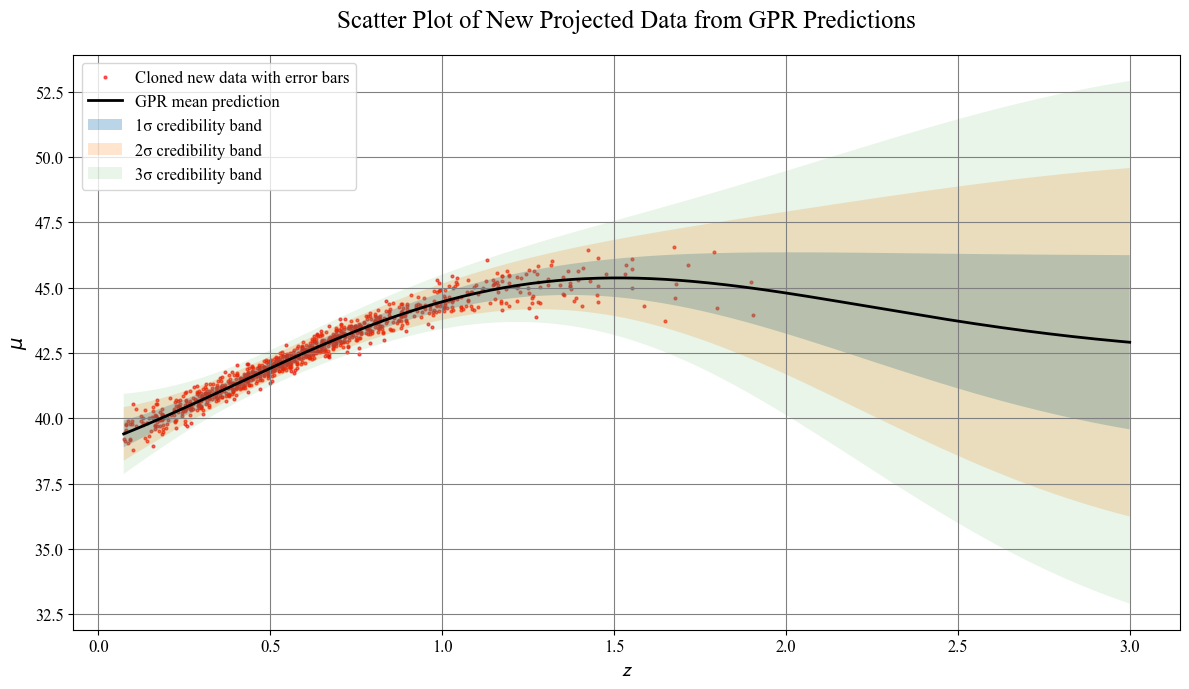

In [67]:
# Scatter plot of the new cloned data
plt.figure(figsize=(12, 7))

# Predict over a dense grid
x_fit = np.linspace(X_train[:, 0].min(), 3, 300).reshape(-1, 1)
y_mean, y_std2 = grid.best_estimator_.predict(x_fit, return_std=True)

# Credibility bands: ±1σ, ±2σ, ±3σ
bands = {
    '1σ': (y_mean.ravel() - 1*y_std2, y_mean.ravel() + 1*y_std2, 0.3),
    '2σ': (y_mean.ravel() - 2*y_std2, y_mean.ravel() + 2*y_std2, 0.2),
    '3σ': (y_mean.ravel() - 3*y_std2, y_mean.ravel() + 3*y_std2, 0.1),
}

plt.scatter(z_new, y_new, marker='o', s=4, alpha=0.6, 
            color='red', label='Cloned new data with error bars')
plt.plot(x_fit, y_mean, 'k-', label='GPR mean prediction')

for label, (lower, upper, alpha) in bands.items():
    plt.fill_between(x_fit.ravel(), lower, upper, alpha=alpha, label=f'{label} credibility band')

plt.xlabel(r"$\mathcal{z}$")
plt.ylabel(r"$\mu$")
plt.title("Scatter Plot of New Projected Data from GPR Predictions")
plt.legend()
plt.grid(True)
plt.show()
